In [1]:
from util import *

import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

Base = Path('.')
Gens = Base / 'generations'
Exps = Base / 'exps'
Uniform2000 = Gens / 'uniform_N2000'

In [2]:
def load_generation(path, beam=1, generate_depth=30, n_route_neighbors=15, ptype='CVRP', n_subproblems=None, subproblem_temperature=0.0):
    s = np.load(path)
    times = s['times']
    n_steps = len(times) # Number of total subsolver steps taken
    
    # ps does not contain repeats of the same problem
    ps = reconstruct_data(s['xys'], s['demands'], s['capacity'], unpack_routes(s['routes']), s['transitions'], s['actions'], s['lkh_dists'], s['lkh_routes'], ptype=ptype, pkwargs=s, generate_depth=generate_depth, n_route_neighbors=n_route_neighbors, n_subproblems=n_subproblems, subproblem_temperature=subproblem_temperature)

    if 'repeats' in s:
        repeats = s['repeats'].astype(np.int32)
        repeats = repeats[:n_steps] # There's an extra repeat if a sequence ends with the action_fn returning []
        assert len(repeats) == n_steps

        ps_iter = iter(ps)
        ps_with_repeats = []
        for i, r in enumerate(repeats):
            ps_with_repeats.append(ps_with_repeats[-r] if r else next(ps_iter))
        try: # The last problem is a new one
            ps_with_repeats.append(next(ps_iter))
        except: # The last problem is repeated
            ps_with_repeats.append(ps_with_repeats[-1])
        assert len(repeats) + 1 == len(ps_with_repeats)
        ps = ps_with_repeats

    dists = np.array([p.total_dist for p in ps])
    times = np.array([0, *times])
    assert len(times) == len(dists)
    return dists, times

def load_gens(data_path, instances=40, runs=1, **kwargs):
    instances = np.arange(instances) if isinstance(instances, int) else instances
    runs = np.arange(runs) if isinstance(runs, int) else runs
    paths = np.array([[data_path / f'{i}{f"_{j}" if j else ""}.npz' for j in runs] for i in instances])
    exists = np.vectorize(lambda p: p.exists())(paths)
    if not exists.all():
        print(f'{(~exists).sum()} runs missing for', data_path)
        print('\n'.join(str(set(np.nonzero(row)[0])) for row in ~exists.T))
        raise RuntimeError
    return np.vectorize(lambda p: Namespace(zip(['dists', 'times'], map(np.array, load_generation(p, **kwargs)))))(paths)

def load_lkh(path):
    multiplier = 1e5
    with open(path, 'r') as f:
        trials = []
        dists = []
        times = []
        for line in f:
            if line.startswith('*'):
                m = re.search(r'(\d+): Cost = ([\d\_]+), Time = ([\d\.]+)', line)
                trial, dist, time = [float(x.replace('_', '')) for x in m.groups()]
                trials.append(trial)
                dists.append(dist / multiplier)
                times.append(time)
    return np.array(trials), np.array(dists), np.array(times)

def load_hgs(path):
    multiplier = 1e4
    with open(path, 'r') as f:
        trials = []
        dists = []
        times = []
        for line in f:
            if line.startswith('It'):
                m = re.search(r'It\s+(\d+)\s+\d+\s+\|\s+T\(s\)\s+([\d\.]+)\s+\|\s+Feas\s+\d+\s+([\d\.]+)\s+', line)
                trial, time, dist = [float(x) for x in m.groups()]
                trials.append(trial)
                dists.append(dist / multiplier)
                times.append(time)
    trials, dists, times = np.array(trials), np.array(dists), np.array(times)
    return trials, np.minimum.accumulate(dists), times

def load_solvers(data_path, instances=40, runs=1, fn=load_lkh):
    instances = np.arange(instances) if isinstance(instances, int) else instances
    def load_ij(i, j):
        steps, dists, times = fn(data_path / f'{i}{f"_{j}" if j else ""}/output.log')
        return Namespace(steps=steps, dists=dists, times=times)
    return np.array([[load_ij(i, j) for j in range(runs)] for i in instances])

get_init_dist = lambda xs, init_reference: np.mean([d[0].dists[0] for d in xs[init_reference]])

def log_interpolate(x, n_points=1000, max_time=None):
    max_time = max_time or max(z.times[-1] for zs in x for z in zs)
    times = np.logspace(np.log(1), np.log(max_time), n_points, base=np.e)
    dists = np.array([[np.interp(times, z.times, z.dists) for z in zs] for zs in x]) # (n_instance, n_runs, n_points)
    return times, dists.mean(axis=0)
    
def get_threshold(x, init_dist, frac=0.95):
    times, dists = log_interpolate(x)
    dists = dists.mean(axis=0) # (n_points,)
    best_dist = dists[-1]
    dist_frac = init_dist * (1 - frac) + best_dist * frac
    i_frac = np.argmax(dists < dist_frac)
    return times[i_frac], dists[i_frac]

def compute_speedup(times, dists_runs, ref_times, ref_dists):
    valid = ref_dists >= dists_runs.min()
    ref_d = ref_dists[valid]
    ref_t = ref_times[valid]
    speedups = ref_t / np.array([np.interp(ref_d[::-1], dists[::-1], times[::-1])[::-1] for dists in dists_runs])
    return speedups.mean(axis=0), speedups.std(axis=0), valid

def plot_speedup(xs, ax, title=None, plot_kwargs=defaultdict(dict), reference='LKH-3', init_reference='Random', ylabel='Speedup Over LKH-3', xlabel='% LKH-3 30k Steps Improvement'):
    ref_times, ref_dists = log_interpolate(xs[reference])
    ref_dists = ref_dists.mean(axis=0)
    
    init_dist = get_init_dist(xs, init_reference)
    final_dist = ref_dists[-1]
    
    for label, data in xs.items():
        if label == reference: continue
        times, dists = log_interpolate(data)
        mean, std, valid = compute_speedup(times, dists, ref_times, ref_dists)
        percent_improvements = (init_dist - ref_dists[valid]) * 100 / (init_dist - final_dist)
        
        kwargs = plot_kwargs[label]
        ax.plot(percent_improvements, mean, label=label, **{'linewidth': 1, **kwargs})
        ax.fill_between(percent_improvements, mean - std, mean + std, alpha=0.3, **kwargs)

    ylabel and ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.legend(fontsize=12)
    ax.set_yscale('log')
    ax.grid()
    ax.set_title(title)
    ax.axvline(95, color='black', linestyle='dashed', zorder=-1)

def print_speedup(xs, reference='LKH-3', init_reference='Random', thresholds=[95], use_std=True):
    ref_times, ref_dists = log_interpolate(xs[reference])
    ref_dists = ref_dists.mean(axis=0)
    
    init_dist = get_init_dist(xs, init_reference)
    final_dist = ref_dists[-1]
    
    all_results = {}
    for label, data in xs.items():
        times, dists = log_interpolate(data)
        mean, std, valid = compute_speedup(times, dists, ref_times, ref_dists)
        
        results = {}
        percent_improvements = (init_dist - ref_dists[valid]) * 100 / (init_dist - final_dist)
        for threshold in thresholds:
            exceed = percent_improvements > threshold
            i = (len(percent_improvements) - 1) if not exceed.any() else np.argmax(exceed)
            if exceed.all():
                results[f'{threshold}%'] = f'N/A'
            elif i >= len(mean):
                results[f'{threshold}%'] = f'N/A'
            elif not use_std:
                results[f'{threshold}%'] = f'{mean[i]:.2f}'
            else:
                results[f'{threshold}%'] = f'{mean[i]:.2f} ± {std[i]:.2f}'
        all_results[label] = results
    return pd.DataFrame(all_results).T

def plot_improvement(xs, ax, title=None, plot_kwargs=defaultdict(dict), reference='LKH-3', init_reference='Random', ylabel='Improvement over LKH-3', ylabel_relative='(% LKH-3 30k Steps Improvement)'):
    ref_data = xs[reference]
    ref_times, ref_dists = log_interpolate(ref_data)
    ref_dists = ref_dists.mean(axis=0)
    
    init_dist = get_init_dist(xs, init_reference)
    thres_time, thres_dist = get_threshold(xs[reference], init_dist)
    final_dist = ref_dists[-1]
    ax_relative = ax.twinx()
    
    max_time = max(z.times[-1] for label, data in xs.items() for zs in data for z in zs)
    for i, (label, data) in enumerate(xs.items()):
        if label == reference: continue
        x, ys = log_interpolate(data, max_time=max_time)
        mean, std = np.interp(x, ref_times, ref_dists) - ys.mean(axis=0), ys.std(axis=0)

        kwargs = plot_kwargs[label]
        ax.plot(x, mean, label=label, **{'linewidth': 1, **kwargs})
        ax.fill_between(x, mean - std, mean + std, alpha=0.3, **kwargs)
        
        passed = ys.mean(axis=0) < thres_dist
        if passed.any() and label.startswith('Ours'):
            ours_thres_time = x[np.argmax(passed)]
            ax.axvline(ours_thres_time, zorder=-1, alpha=0.5, **kwargs)

    ax.grid()
    ylabel and ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.legend(fontsize=12)
    ax.set_xlim([1, None])
    ax.set_xscale('log')
    ax.set_title(title)
    ax_relative.set_ylim(ax.get_ylim() / (init_dist - final_dist) * 100)
    ylabel_relative and ax_relative.set_ylabel(ylabel_relative, fontsize=12)
    return ax_relative

def plot_time_cost(xs, ax, title=None, plot_kwargs=defaultdict(dict), ylabel='Total Cost', reference='LKH-3', init_reference='Random'):
    init_dist = get_init_dist(xs, init_reference)
    ax.axhline(init_dist, linestyle='dotted', color='black')
    thres_time, thres_dist = get_threshold(xs[reference], init_dist)

    xmin, ymin, ymax = np.inf, init_dist, init_dist
    for label, data in xs.items():            
        x, ys = log_interpolate(data)
        mean, std = ys.mean(axis=0), ys.std(axis=0)
        kwargs = plot_kwargs[label]
        ax.plot(x, mean, label=label, **{'linewidth': 1, **kwargs})
        ax.fill_between(x, mean - std, mean + std, alpha=0.3, **kwargs)
        
        passed = ys.mean(axis=0) < thres_dist
        if passed.any() and label.startswith('Ours'):
            ax.axvline(x[np.argmax(passed)], zorder=-1, alpha=0.5, **kwargs)
        if label == reference:
            ax.axhline(thres_dist, zorder=-1, alpha=0.5, **kwargs)
        if not label.startswith(reference):
            ymin = min(ymin, (mean - std).min())
            ymax = max(ymax, (mean + std).max())
            xmin = min(xmin, x.min())
    ax.grid()
    ylabel and ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_xscale('log')
    ax.set_ylim([ymin - 0.25, ymax + 0.25])
    ax.set_xlim([1, None])
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
    title and ax.set_title(title)

In [3]:
instances = 10 # Can use 40 problem instances, but will take 4x longer to load
runs = 1 # Can use 5 trajectories with different seeds per instance, but will take 5x longer to load

exp = Exps / 'uniform_merge_routeneighbors10/subp_rotate_flip_layers6_heads8_lr0.001_batch2048'
xs = {
'LKH-3': load_solvers(Uniform2000 / 'lkh/test', instances=instances, runs=runs),
'Random': load_gens(
    Uniform2000 / 'subproblem_selection_lkh/test_routeneighbors10_beam1_sample_depth1200_improve0.0_nodup', instances=instances, runs=runs, generate_depth=1200, n_route_neighbors=10, ptype='CVRP'), # generate_depth, n_route_neighbors, and ptype must be same as the generating command
'Ours': load_gens(exp / 'generations_uniform_N2000_test_beam1_depth1200_improve0.0_nodup_lkh500/40000', instances=instances, runs=runs, generate_depth=1200, n_route_neighbors=10, ptype='CVRP'), # generate_depth, n_route_neighbors, and ptype must be same as the generating command
}

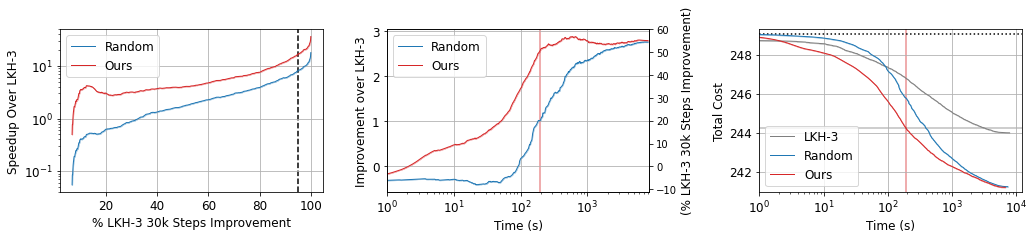

In [4]:
fig, (ax_speedup, ax_improvement, ax_time_cost) = plt.subplots(1, 3, figsize=(16, 3), sharey=False)
plot_kwargs = {
    'LKH-3': dict(color='C7'),
    'Random': dict(color='C0'),
    'Ours': dict(color='C3'),
}
plot_speedup(xs, ax=ax_speedup, plot_kwargs=plot_kwargs, reference='LKH-3', init_reference='Random')
ax_speedup.set_position(np.array(ax_speedup.get_position().bounds) - [0.06, 0, 0, 0])
plot_improvement(xs, ax=ax_improvement, plot_kwargs=plot_kwargs, reference='LKH-3', init_reference='Random')
ax_improvement.set_position(np.array(ax_improvement.get_position().bounds) - [0.05, 0, 0, 0])
plot_time_cost(xs, ax=ax_time_cost, plot_kwargs=plot_kwargs, reference='LKH-3', init_reference='Random')

for ax in (ax_speedup, ax_improvement, ax_time_cost):
    ax.tick_params(axis='both', labelsize=12)
plt.show()

In [5]:
print_speedup(xs, reference='LKH-3', init_reference='Random', use_std=False)

,95%
LKH-3,1.00
Random,8.12
Ours,16.64
